# *Анализ данных "Facebook comments" и построение модели линейной регрессии с гребневой регуляризацией*

In [77]:
import numpy as np
import pandas as pd
import shap
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from pandas import DataFrame, Series
from typing import NoReturn, List
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

### *Вспомогательные функции*

In [2]:
def save_df2csv(df: pd.DataFrame, csv_file_name: str = "from_jupyter.csv") -> NoReturn:
    try:
        df.to_csv(csv_file_name, index=False)
    except NameError as err:
        print(f"Error: {err}")

In [3]:
#save_df2csv(reader_wo_dupl_ohe_freq, "reader_wo_dupl.csv")

### *Загрузка [данных][1]*

[1]: https://www.kaggle.com/kiranraje/prediction-facebook-comment

In [4]:
reader = pd.read_csv("./data/Dataset.csv")

### *Простой анализ данных*

In [5]:
reader.shape

(40949, 28)

In [6]:
reader.head()

,likes,Checkins,Returns,Category,commBase,comm24,comm48,comm24_1,diff2448,baseTime,...,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,output
0,634995,0,463.0,1.0,0.0,0,0.0,0,0,65,...,0,0,0,0.0,0,0,0,0,1,0
1,634995,0,463.0,1.0,0.0,0,0.0,0,0,10,...,0,0,0,0.0,0,0,0,1,0,0
2,634995,0,463.0,1.0,0.0,0,0.0,0,0,14,...,1,0,0,0.0,0,0,0,0,1,0
3,634995,0,463.0,1.0,7.0,0,3.0,7,-3,62,...,1,0,0,1.0,0,0,0,0,0,0
4,634995,0,463.0,1.0,1.0,0,0.0,1,0,58,...,0,0,0,0.0,0,1,0,0,0,0


In [7]:
reader.select_dtypes(include=['float64', 'int64'])

,likes,Checkins,Returns,Category,commBase,comm24,comm48,comm24_1,diff2448,baseTime,...,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,output
0,634995,0,463.0,1.0,0.0,0,0.0,0,0,65,...,0,0,0,0.0,0,0,0,0,1,0
1,634995,0,463.0,1.0,0.0,0,0.0,0,0,10,...,0,0,0,0.0,0,0,0,1,0,0
2,634995,0,463.0,1.0,0.0,0,0.0,0,0,14,...,1,0,0,0.0,0,0,0,0,1,0
3,634995,0,463.0,1.0,7.0,0,3.0,7,-3,62,...,1,0,0,1.0,0,0,0,0,0,0
4,634995,0,463.0,1.0,1.0,0,0.0,1,0,58,...,0,0,0,0.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,7170111,70,497000.0,9.0,269.0,14,58.0,240,-44,56,...,0,0,0,0.0,0,0,0,1,0,1
40945,7170111,70,497000.0,9.0,644.0,20,106.0,619,-86,53,...,0,0,0,0.0,0,0,0,1,0,2
40946,7170111,70,497000.0,9.0,620.0,620,0.0,620,620,19,...,0,0,0,0.0,0,0,1,0,0,72
40947,7170111,70,497000.0,9.0,629.0,189,440.0,588,-251,33,...,0,0,0,0.0,0,0,0,1,0,28


### *Построение аналитического отчета с помощью [pandas_profiling](https://github.com/pandas-profiling/pandas-profiling)*

In [8]:
#profile = ProfileReport(reader, title="Pandas Profiling Report", explorative=True)

In [9]:
#profile.to_notebook_iframe()

In [10]:
#profile.to_file("Facebook_Comments_for_Line_Regression_Report.html")

### *Удаление строк-дублей*

In [11]:
reader[reader.duplicated()] # это строки-дубли

,likes,Checkins,Returns,Category,commBase,comm24,comm48,comm24_1,diff2448,baseTime,...,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,output
3082,5970921,53096,234501.0,9.0,20.0,20,0.0,20,20,12,...,0,0,0,NaN,0,0,0,0,0,12
4894,4290409,11,131422.0,9.0,155.0,10,36.0,136,-26,62,...,0,0,1,0.0,0,0,0,0,0,1
4936,4290409,11,131422.0,9.0,164.0,14,73.0,146,-59,53,...,0,0,0,0.0,1,0,0,0,0,0
14010,25599,2023,1835.0,32.0,0.0,0,0.0,0,0,6,...,0,0,0,0.0,0,0,1,0,0,0
15808,1670,0,8.0,13.0,0.0,0,0.0,0,0,38,...,1,0,1,0.0,0,0,0,0,0,0
22031,4685,11267,391.0,32.0,0.0,0,0.0,0,0,5,...,1,0,0,0.0,0,0,0,1,0,0
26081,2736,491,277.0,54.0,1.0,0,0.0,1,0,51,...,0,0,0,0.0,0,0,0,1,0,0
36304,296,165,1.0,56.0,0.0,0,0.0,0,0,64,...,0,0,0,0.0,0,0,0,1,0,0


In [12]:
reader_wo_dupl = reader.drop_duplicates().reset_index(drop=True) # наборе данных без строк-дублей

In [13]:
reader_wo_dupl.columns

Index(['likes', 'Checkins', 'Returns', 'Category', 'commBase', 'comm24',
       'comm48', 'comm24_1', 'diff2448', 'baseTime', 'length', 'shares', 'hrs',
       'sun_pub', 'mon_pub', 'tue_pub', 'wed_pub', 'thu_pub', 'fri_pub',
       'sat_pub', 'sun_base', 'mon_base', 'tue_base', 'wed_base', 'thu_base',
       'fri_base', 'sat_base', 'output'],
      dtype='object')

### *Анализ пропущенных значений*

In [14]:
val_counts = reader_wo_dupl['likes'].value_counts()

In [15]:
reader_wo_dupl.columns

Index(['likes', 'Checkins', 'Returns', 'Category', 'commBase', 'comm24',
       'comm48', 'comm24_1', 'diff2448', 'baseTime', 'length', 'shares', 'hrs',
       'sun_pub', 'mon_pub', 'tue_pub', 'wed_pub', 'thu_pub', 'fri_pub',
       'sat_pub', 'sun_base', 'mon_base', 'tue_base', 'wed_base', 'thu_base',
       'fri_base', 'sat_base', 'output'],
      dtype='object')

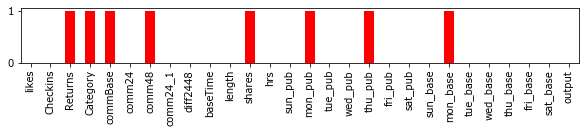

In [16]:
# Признаки с отсутствующими значениямиа
fig, ax = plt.subplots(figsize=(10, 1))
reader_wo_dupl.isna().any().map({False : 0, True : 1}).plot.bar(color='red');

In [17]:
mask_cols_na = reader_wo_dupl.isna().any()

In [18]:
# Список признаков, в которых есть хотя бы один пропуск
list_cols_na = mask_cols_na[mask_cols_na == True].index.tolist()

In [19]:
reader_only_na_cols = reader_wo_dupl.loc[:, list_cols_na]

In [20]:
# Число пропущенных значений в каждом столбце
reader_only_na_cols.isna().sum().sort_values()

comm48        48
Returns       51
Category      57
commBase      60
mon_pub     1927
mon_base    1969
shares      2448
thu_pub     3045
dtype: int64

### *Анализ признака* **Returns**

In [21]:
# Индексы выбросов
outl_idx = reader_wo_dupl['Returns'].nlargest(7).index
reader_wo_dupl['Returns'].loc[outl_idx] = np.nan

In [22]:
# Замещение пропущенных значений средним
reader_wo_dupl['Returns'] = reader_wo_dupl['Returns'].fillna(reader_wo_dupl['Returns'].mean())

### *Анализ признака* **Category**

<AxesSubplot:>

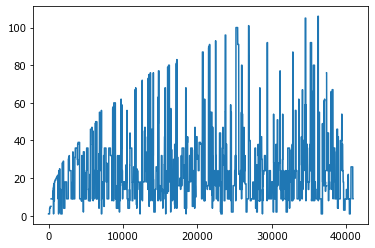

In [23]:
reader_wo_dupl['Category'].plot()

In [24]:
reader_wo_dupl['Category'].isna().sum()

57

In [25]:
reader_wo_dupl['Category'].describe()

count    40884.000000
mean        24.271965
std         19.951025
min          1.000000
25%          9.000000
50%         18.000000
75%         32.000000
max        106.000000
Name: Category, dtype: float64

In [26]:
reader_wo_dupl['Category'] = reader_wo_dupl['Category'].interpolate()

### *Анализ признака* **commBase**

<AxesSubplot:>

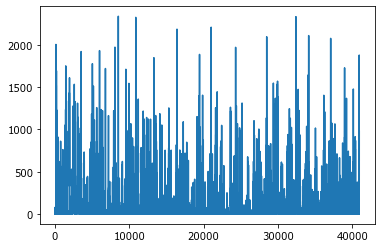

In [27]:
reader_wo_dupl['commBase'].plot()

In [28]:
reader_wo_dupl['commBase'].value_counts()

0.0      6691
1.0      2837
2.0      2108
3.0      1728
4.0      1384
         ... 
661.0       1
596.0       1
826.0       1
811.0       1
884.0       1
Name: commBase, Length: 970, dtype: int64

In [29]:
reader_wo_dupl['commBase'].isna().sum()

60

In [30]:
reader_wo_dupl['commBase'].describe()

count    40881.000000
mean        55.796385
std        137.072709
min          0.000000
25%          2.000000
50%         11.000000
75%         46.000000
max       2341.000000
Name: commBase, dtype: float64

In [31]:
reader_wo_dupl['commBase'].nunique()

970

In [32]:
# Так как у признака много уникальных значений, имеет смысл перейти к частотам
reader_wo_dupl['commBase'] = reader_wo_dupl['commBase']/reader_wo_dupl.shape[0]

In [33]:
reader_wo_dupl['commBase'] = reader_wo_dupl['commBase'].interpolate()

### *Анализ признака* **comm48**

<AxesSubplot:>

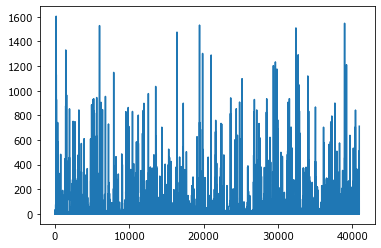

In [34]:
reader_wo_dupl['comm48'].plot()

In [35]:
reader_wo_dupl['comm48'].describe()

count    40893.000000
mean        19.673783
std         71.123143
min          0.000000
25%          0.000000
50%          0.000000
75%          9.000000
max       1605.000000
Name: comm48, dtype: float64

In [36]:
reader_wo_dupl['comm48'] = reader_wo_dupl['comm48'].interpolate()

### *Анализ признака* **shares**

<AxesSubplot:>

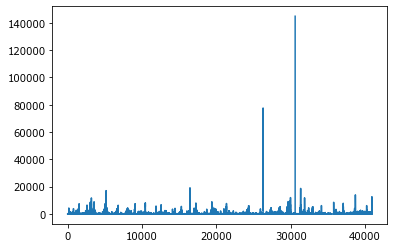

In [37]:
reader_wo_dupl['shares'].plot()

In [38]:
reader_wo_dupl['shares'].loc[reader_wo_dupl['shares'].nlargest(3).index] = np.nan

In [39]:
reader_wo_dupl['shares'] = reader_wo_dupl['shares'].interpolate()

### *Анализ признака* **mom_pub**

<AxesSubplot:>

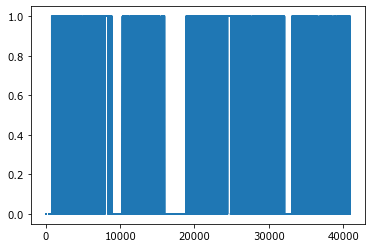

In [40]:
reader_wo_dupl['mon_pub'].plot()

In [41]:
reader_wo_dupl['mon_pub'] = reader_wo_dupl['mon_pub'].fillna(method='ffill')

### *Анализ признака* **thu_pub**

<AxesSubplot:>

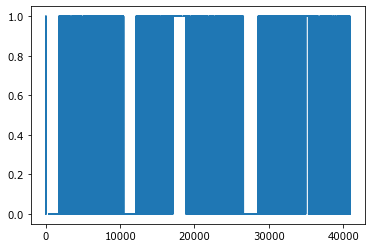

In [42]:
reader_wo_dupl['thu_pub'].plot()

In [43]:
reader_wo_dupl['thu_pub'] = reader_wo_dupl['thu_pub'].fillna(method='ffill')

In [44]:
reader_wo_dupl['thu_pub'].value_counts()

0.0    33463
1.0     7478
Name: thu_pub, dtype: int64

### *Анализ признака* **mon_base**

<AxesSubplot:>

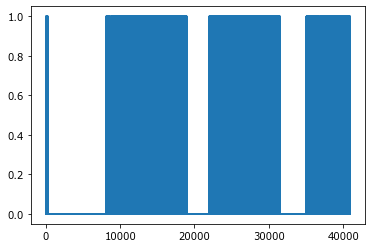

In [45]:
reader_wo_dupl['mon_base'].plot()

In [46]:
reader_wo_dupl['mon_base'] = reader_wo_dupl['mon_base'].fillna(method='ffill')

In [47]:
reader_wo_dupl['mon_base'].value_counts()

0.0    37483
1.0     3458
Name: mon_base, dtype: int64

In [48]:
mask_dupl_sec = reader_wo_dupl.duplicated()

In [49]:
reader_wo_dupl = reader_wo_dupl.drop_duplicates().reset_index(drop=True)

### *Кодирование признаков*

In [50]:
def feature2ohe_transform(feature: pd.DataFrame, feature_name: str) -> pd.DataFrame:
    '''
    Проводит прямое кодирование категориального признака.
    -----------
    Возвращает OHE-DataFrame
    '''
    ohe = OneHotEncoder().fit(feature)
    feature_ohe = ohe.transform(feature).toarray()
    cat_nums = len(ohe.categories_[0])
    
    return DataFrame(feature_ohe, columns=[f'{feature_name}_{i}' for i in range(1, cat_nums+1)])

In [51]:
def select_feature_with_2_unique(df: pd.DataFrame) -> list:
    '''
    Отбирает бинарные признаки
    -----------
    Возвращает список имен бинарных признаков
    '''
    binary_cat_features = []
    for col in df.columns:
        if df[col].nunique() == 2:
            binary_cat_features.append(col)
    return binary_cat_features

lst_of_binary_features = select_feature_with_2_unique(reader_wo_dupl)

In [52]:
lst_of_binary_features

['sun_pub',
 'mon_pub',
 'tue_pub',
 'wed_pub',
 'thu_pub',
 'fri_pub',
 'sat_pub',
 'sun_base',
 'mon_base',
 'tue_base',
 'wed_base',
 'thu_base',
 'fri_base',
 'sat_base']

In [53]:
def df2ohedf(df: pd.DataFrame, lst: list):
    '''
    Возвращает OHE-DataFrame без исходных бинарных признаков
    '''
    df = df.copy()
    lst_ohe_df = []
    for col in lst:
        lst_ohe_df.append(feature2ohe_transform(df[[col]], col))
    res = pd.concat([df, *lst_ohe_df], axis=1)
    return res.drop(lst, axis=1)

In [54]:
#reader_wo_dupl_ohe = df2ohedf(reader_wo_dupl, lst_of_binary_features)

In [55]:
reader_wo_dupl_ohe = df2ohedf(reader_wo_dupl, ['Category'])
reader_wo_dupl_ohe = df2ohedf(reader_wo_dupl_ohe, ['hrs'])

In [56]:
def feature2frequency_code(df: pd.DataFrame, feature_name: str) -> pd.Series:
    '''
    Выполняет кодировку частотой
    --------------
    Возвращает закодированный признак
    '''
    freq = df.loc[:, feature_name].value_counts() / df.shape[0]
    return df.loc[:, feature_name].map(freq)

In [57]:
lst_for_cat2numeric = [
    'likes',
    'Checkins',
    'Returns',
    'commBase',
    'comm24',
    'comm24_1',
    'comm48',
    'diff2448',
    'baseTime',
    'length',
    #'shares',
]

In [58]:
def df2freqcode(df: pd.DataFrame, lst: list):
    for col in lst:
        df[f'{col}_freq'] = feature2frequency_code(df, col)
    return df

In [59]:
reader_wo_dupl_ohe_freq = df2freqcode(reader_wo_dupl_ohe, lst_for_cat2numeric)

### *Удаление признаков*

In [60]:
reader_wo_dupl_ohe_freq=reader_wo_dupl_ohe_freq.drop(['shares'],axis='columns')
reader_wo_dupl_ohe_freq=reader_wo_dupl_ohe_freq.drop(['mon_pub'],axis='columns')
reader_wo_dupl_ohe_freq=reader_wo_dupl_ohe_freq.drop(['thu_pub'],axis='columns')
reader_wo_dupl_ohe_freq=reader_wo_dupl_ohe_freq.drop(['mon_base'],axis='columns')
reader_wo_dupl_ohe_freq=reader_wo_dupl_ohe_freq.drop(['comm24_1'],axis='columns')
reader_wo_dupl_ohe_freq=reader_wo_dupl_ohe_freq.drop(['comm24_1_freq'],axis='columns')

In [61]:
set(reader_wo_dupl_ohe_freq.columns).difference(set(f'Category_{i}' for i in range(1,103)))

{'Checkins',
 'Checkins_freq',
 'Returns',
 'Returns_freq',
 'baseTime',
 'baseTime_freq',
 'comm24',
 'comm24_freq',
 'comm48',
 'comm48_freq',
 'commBase',
 'commBase_freq',
 'diff2448',
 'diff2448_freq',
 'fri_base',
 'fri_pub',
 'hrs_1',
 'hrs_10',
 'hrs_11',
 'hrs_12',
 'hrs_13',
 'hrs_14',
 'hrs_15',
 'hrs_16',
 'hrs_17',
 'hrs_18',
 'hrs_19',
 'hrs_2',
 'hrs_20',
 'hrs_21',
 'hrs_22',
 'hrs_23',
 'hrs_24',
 'hrs_3',
 'hrs_4',
 'hrs_5',
 'hrs_6',
 'hrs_7',
 'hrs_8',
 'hrs_9',
 'length',
 'length_freq',
 'likes',
 'likes_freq',
 'output',
 'sat_base',
 'sat_pub',
 'sun_base',
 'sun_pub',
 'thu_base',
 'tue_base',
 'tue_pub',
 'wed_base',
 'wed_pub'}

### *Подготовка модели*

In [62]:
target = 'output'
features = list(set(reader_wo_dupl_ohe_freq.columns).difference({target}))

In [63]:
X = reader_wo_dupl_ohe_freq.loc[:, features]
y = reader_wo_dupl_ohe_freq.loc[:, target]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [65]:
X_train

,Category_85,tue_pub,Category_26,Category_17,Category_59,Category_67,Category_83,hrs_19,Category_29,fri_pub,...,Category_52,Category_63,hrs_16,Category_60,Category_43,Category_20,Category_74,comm48,Category_50,Category_98
13878,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28558,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,48.0,0.0,0.0
26767,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35892,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36272,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18065,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1254,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
899,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

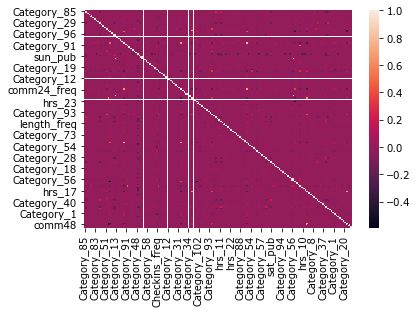

In [66]:
import seaborn as sns
sns.heatmap(X_train.corr())

### *Линейная регрессия*

In [86]:
lr = LinearRegression().fit(X_train, y_train)

In [89]:
r2_score_test = r2_score(y_test, lr.predict(X_test)); print(f"R^2 = {r2_score_test:.3f}")

R^2 = 0.296


In [70]:
explainer = shap.LinearExplainer(lr, X_train)
shap_values = explainer.shap_values(X_train)

In [71]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_train.iloc[0, :]
)

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [90]:
rf = RandomForestRegressor(n_estimators=250, n_jobs=-1).fit(X_train, y_train)

In [92]:
r2_score_test = r2_score(y_test, rf.predict(X_test));  print(f"R^2 = {r2_score_test:.3f}")

R^2 = 0.623
